In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [ ]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import zipfile
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import cv2 as cv2
from google.colab.patches import cv2_imshow
from keras.applications import mobilenet_v2
from tensorflow.keras.models import Sequential

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!rm -r "/content/testSet_divided_centered_square"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Preprocessing_638/trainingSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Preprocessing_638/validationSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/testSet.zip" -d "/content"

#import training validation and test sets

In [ ]:
BATCH_SIZE = 100
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
training_dir = PATH = '/content/trainingSet/'
validation_dir = PATH = '/content/validationSet/'

training_dataset = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 3190 files belonging to 5 classes.
Found 3510 files belonging to 5 classes.


In [ ]:
test_dir = PATH = '/content/testSet/'

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 53576 files belonging to 5 classes.


## Load Test True labels


In [ ]:
true_labels = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)

In [ ]:
tosave = np.array(true_labels)
np.save('/content/drive/Shareddrives/DeepLearningProject/true_labels.npy', tosave)

In [ ]:
#load directly numpy file
true_labels = np.load("/content/drive/Shareddrives/DeepLearningProject/true_labels.npy")

# Utility functions

In [ ]:
def load_models(pathFolder):
  listFiles = os.listdir(pathFolder)
  listFiles.sort() #ordered by acc
  listModels = []
  for file in tqdm.tqdm(listFiles):
    model = tf.keras.models.load_model(os.path.join(pathFolder, file))
    nameModel = file.split(".h*")[0]
    elem = {'name':nameModel, 'model':model, 'accuracy':nameModel.split("_")[0]}
    listModels.append(elem)
  return listModels

def predict_models_save_npy(listModels):
  listResults = []
  for iteration,elem in tqdm.tqdm(enumerate(listModels)):
    score = elem['model'].predict(test_dataset)
    tosave = np.array(score)
    np.save(os.path.join('/content/drive/Shareddrives/DeepLearningProject/predictions/', listModels[iteration]['name']+".npy"), tosave) 

def load_model_scores(pathFolder):
  listFiles = os.listdir(pathFolder)
  listFiles.sort() #ordered by acc
  listScores = []
  for file in tqdm.tqdm(listFiles):
    scores = np.load(os.path.join(pathFolder, file))
    scores = np.argmax(scores, -1)
    nameScore = file.split(".npy")[0]
    elem = {'name':nameScore, 'scores':scores, 'accuracy':nameScore.split("_")[0]}
    listScores.append(elem)
  return listScores

# Load models

In [ ]:
pathModels = "/content/drive/Shareddrives/DeepLearningProject/models/Model4Ensamble/"
pathScores = "/content/drive/Shareddrives/DeepLearningProject/predictions"

In [ ]:
classifiers_weights = [0.27219, 2.87548,1.32743, 8.04673, 9.92203]

In [ ]:
metric = [
          {'name': '23_pretrained_VGG16_exp4_doubleTrain_638c_00001_Adam',    'recall': [0.24, 0.60, 0.12, 0.02, 0.03], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.36, 0.13, 0.13, 0.02, 0.03] },
          {'name': '31_pretrained_MobileNet_exp1_SGD_638c_00001',             'recall': [0.33, 0.34, 0.25, 0.04, 0.05], 'precision': [0.74, 0.07, 0.14, 0.03, 0.03], 'f1score': [0.46, 0.12, 0.18, 0.03, 0.03] },
          {'name': '47_pretrained_MobileNet_exp3.1_adam_638c_00001',          'recall': [0.58, 0.19, 0.13, 0.01, 0.07], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.65, 0.10, 0.14, 0.02, 0.03] },
          {'name': '35_pretrained_VGG16_exp3_638c_00001_Adam',                'recall': [0.42, 0.44, 0.07, 0.03, 0.03], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.54, 0.12, 0.10, 0.03, 0.02] },
          {'name': '38_pretrained_VGG16_exp1_638c_00001_Adam',                'recall': [0.45, 0.25, 0.20, 0.05, 0.04], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.56, 0.11, 0.17, 0.03, 0.03] },
          {'name': '42_pretrained_VGG16_exp2_638c_00001_Adam',                'recall': [0.50, 0.22, 0.21, 0.05, 0.04], 'precision': [0.74, 0.07, 0.14, 0.03, 0.02], 'f1score': [0.60, 0.11, 0.17, 0.04, 0.03] },
          {'name': '43_pretrained_MobileNet_exp3_adam_638c_0001',             'recall': [0.52, 0.27, 0.14, 0.01, 0.06], 'precision': [0.74, 0.07, 0.15, 0.03, 0.02], 'f1score': [0.61, 0.11, 0.14, 0.02, 0.03] },
          {'name': '44_pretrained_MobileNet_exp4_SGD_638c_0001',              'recall': [0.55, 0.25, 0.12, 0.02, 0.05], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.63, 0.11, 0.14, 0.02, 0.03] },
          {'name': '45_pretrained_MobileNet_exp3_SGD_638c_0001',              'recall': [0.57, 0.25, 0.11, 0.02, 0.07], 'precision': [0.74, 0.07, 0.15, 0.03, 0.02], 'f1score': [0.64, 0.11, 0.13, 0.02, 0.03] },
          {'name': '45_pretrained_VGG16_exp3_638c_0001_SGD',                  'recall': [0.56, 0.28, 0.10, 0.01, 0.04], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.63, 0.11, 0.12, 0.01, 0.03] },
          {'name': '46_pretrained_VGG16_exp6_onmodel3_638c_0001_Adam',        'recall': [0.58, 0.27, 0.11, 0.03, 0.02], 'precision': [0.74, 0.07, 0.16, 0.02, 0.02], 'f1score': [0.65, 0.11, 0.13, 0.03, 0.02] },
          {'name': '48_pretrained_MobileNet_exp2_adam_638c_0001',             'recall': [0.60, 0.25, 0.10, 0.01, 0.04], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.66, 0.11, 0.12, 0.01, 0.03] },
          {'name': '50_CNN_Scratch_model1',                                   'recall': [0.64, 0.27, 0.01, 0.03, 0.06], 'precision': [0.74, 0.07, 0.14, 0.03, 0.03], 'f1score': [0.69, 0.11, 0.02, 0.03, 0.04] },
          {'name': '50_pretrained_MobileNet_exp7_model3.1_638c_00001',        'recall': [0.65, 0.25, 0.07, 0.00, 0.06], 'precision': [0.74, 0.07, 0.16, 0.02, 0.03], 'f1score': [0.69, 0.11, 0.10, 0.01, 0.04] },
          {'name': '51_CNN_Scratch_model4',                                      'recall': [0.66, 0.14, 0.02, 0.10, 0.08], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.07, 0.09, 0.04, 0.04, 0.04] },
          {'name': '51_pretrained_MobileNet_exp5_model4_doubletrain_638c_00001', 'recall': [0.65, 0.10, 0.15, 0.08, 0.03], 'precision': [0.74, 0.07, 0.15, 0.02, 0.02], 'f1score': [0.69, 0.08, 0.15, 0.04, 0.03] },
          {'name': '51_pretrained_VGG16_exp5_onmodel3_638c_0001_Adam',        'recall': [0.65, 0.20, 0.12, 0.01, 0.03], 'precision': [0.74, 0.08, 0.15, 0.02, 0.02], 'f1score': [0.69, 0.11, 0.13, 0.01, 0.03] },
          {'name': '52_CNN_Scratch_model2',                                   'recall': [0.68, 0.26, 0.02, 0.01, 0.03], 'precision': [0.74, 0.07, 0.14, 0.02, 0.02], 'f1score': [0.71, 0.11, 0.03, 0.01, 0.03] },
          {'name': '53_pretrained_MobileNet_exp6_model4_638c_00001',          'recall': [0.70, 0.15, 0.07, 0.05, 0.02], 'precision': [0.74, 0.07, 0.16, 0.02, 0.02], 'f1score': [0.72, 0.10, 0.09, 0.03, 0.02] },
          {'name': '54_pretrained_MobileNet_exp7_model4_638c_00001',          'recall': [0.71, 0.21, 0.04, 0.01, 0.04], 'precision': [0.74, 0.07, 0.14, 0.02, 0.02], 'f1score': [0.73, 0.11, 0.06, 0.01, 0.03] },
          {'name': '56_pretrained_MobileNet_exp4_adam_638c_0001',             'recall': [0.73, 0.16, 0.04, 0.02, 0.05], 'precision': [0.74, 0.07, 0.14, 0.02, 0.02], 'f1score': [0.74, 0.09, 0.06, 0.02, 0.03] },
          {'name': '59_CNN_Scratch_model3',                                   'recall': [0.79, 0.08, 0.02, 0.05, 0.07], 'precision': [0.74, 0.07, 0.13, 0.02, 0.02], 'f1score': [0.76, 0.07, 0.04, 0.03, 0.04] },
          {'name': '60_pretrained_MobileNet_exp5_model3.1_doubletrain_638c_00001', 'recall': [0.80, 0.05, 0.08, 0.02, 0.04], 'precision': [0.74, 0.06, 0.14, 0.02, 0.02], 'f1score': [0.77, 0.06, 0.10, 0.02, 0.03] },
          {'name': '67_CNN_Scratch_model7',                                   'recall': [0.89, 0.00, 0.01, 0.00, 0.01], 'precision': [0.74, 0.00, 0.15, 0.02, 0.02], 'f1score': [0.81, 0.00, 0.12, 0.01, 0.01] }
]

In [ ]:
listModels = load_models(pathModels)

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


In [ ]:
predict_models_save_npy(listModels)

5it [13:36, 163.38s/it]


In [ ]:
!rm -r "/content/drive/Shareddrives/DeepLearningProject/predictions/.ipynb_checkpoints"

model_score_test = load_model_scores(pathScores)

rm: cannot remove '/content/drive/Shareddrives/DeepLearningProject/predictions/.ipynb_checkpoints': No such file or directory


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


In [ ]:
print(len(model_score_test))
print()
for elem in model_score_test:
  print(elem)

24

{'name': '23_pretrained_VGG16_exp4_doubleTrain_638c_00001_Adam', 'scores': array([2, 0, 1, ..., 0, 0, 1]), 'accuracy': '23'}
{'name': '31_pretrained_MobileNet_exp1_SGD_638c_00001', 'scores': array([2, 3, 2, ..., 0, 0, 0]), 'accuracy': '31'}
{'name': '35_pretrained_VGG16_exp3_638c_00001_Adam', 'scores': array([1, 0, 0, ..., 1, 1, 0]), 'accuracy': '35'}
{'name': '38_pretrained_VGG16_exp1_638c_00001_Adam', 'scores': array([0, 3, 2, ..., 1, 1, 0]), 'accuracy': '38'}
{'name': '42_pretrained_VGG16_exp2_638c_00001_Adam', 'scores': array([0, 0, 0, ..., 0, 0, 2]), 'accuracy': '42'}
{'name': '43_pretrained_MobileNet_exp3_adam_638c_0001', 'scores': array([1, 2, 0, ..., 2, 1, 0]), 'accuracy': '43'}
{'name': '44_pretrained_MobileNet_exp4_SGD_638c_0001', 'scores': array([2, 4, 1, ..., 0, 2, 1]), 'accuracy': '44'}
{'name': '45_pretrained_MobileNet_exp3_SGD_638c_0001', 'scores': array([1, 2, 0, ..., 0, 4, 0]), 'accuracy': '45'}
{'name': '45_pretrained_VGG16_exp3_638c_0001_SGD', 'scores': array([1,

#Ensemble methods

## Majority voting

In [ ]:
from collections import Counter

ensemble_scores = []

n_models = len(model_score_test)

for i in range(len(true_labels)):
  listVotes = [0, 0, 0, 0, 0]
  listMaxVotes = [0.0, 0.0, 0.0, 0.0, 0.0]
  maxVote = -1
  for iteration,model_score in enumerate(model_score_test):
    accuracy = model_score['accuracy']
    score = model_score['scores'][i]
    if int(listMaxVotes[score]) < int(accuracy):
      listMaxVotes[score] = int(accuracy)
    listVotes[score] += 1
  
  majority_vote = max(listVotes)
  # situazione di pareggio, prendo la scelta con il classificatore maggiore
  if listVotes.count(majority_vote)>1:
    majority_acc = 0
    result = -1
    for iteration,elem in enumerate(listVotes):
      if elem == majority_vote:
          if majority_acc < listMaxVotes[iteration]:
            majority_acc = listMaxVotes[iteration]
            result = iteration
    ensemble_scores.append(result)      
  else:
    ensemble_scores.append(listVotes.index(max(listVotes)))

ensemble_predictions = np.array(ensemble_scores)

Accuracy on Test Data: 73.23%
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     39533
           1       0.08      0.01      0.02      3762
           2       0.21      0.00      0.00      7861
           3       0.00      0.00      0.00      1214
           4       0.00      0.00      0.00      1206

    accuracy                           0.73     53576
   macro avg       0.21      0.20      0.17     53576
weighted avg       0.58      0.73      0.63     53576



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


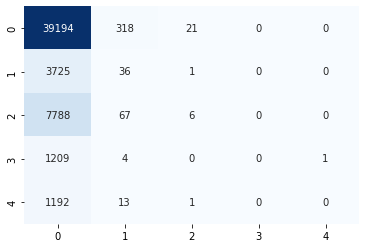

In [ ]:
y_true_cat = np.argmax(true_labels, -1)
pred_Y_cat = np.argmax(ensemble_predictions, -1)
pred_Y_cat = ensemble_predictions

from sklearn.metrics import accuracy_score, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_true_cat, pred_Y_cat)*100))
print(classification_report(y_true_cat, pred_Y_cat))

import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

## Averaging Ensemble Accuracy

In [ ]:
def calculate_weights_accuracy(listModels):
  listAccuracy = []
  for elem in listModels:
    listAccuracy.append(float(elem['accuracy']))

  Sum = sum(listAccuracy)

  listWeights= []

  for elem in listAccuracy:
    listWeights.append(float(elem/Sum)*1000)
  return listWeights

In [ ]:
listWeights = calculate_weights_accuracy(model_score_test)

In [ ]:
listWeights

[20.15775635407537,
 27.169149868536373,
 30.67484662576687,
 33.30411919368974,
 36.809815950920246,
 37.686240140227866,
 38.562664329535494,
 39.43908851884312,
 39.43908851884312,
 40.31551270815074,
 41.19193689745837,
 42.068361086766,
 43.821209465381244,
 43.821209465381244,
 44.697633654688865,
 44.697633654688865,
 44.697633654688865,
 45.57405784399649,
 46.45048203330412,
 47.32690622261175,
 49.079754601226995,
 51.70902716914986,
 52.58545135845749,
 58.72042068361087]

In [ ]:
ensemble_scores = []

n_models = len(model_score_test)
counter = 0

for i in range(len(true_labels)):
  listVotes = [0.0, 0.0, 0.0, 0.0, 0.0]
  for iteration,model_score in enumerate(model_score_test):
    accuracy = model_score['accuracy']
    score = model_score['scores'][i]
    listVotes[score] += 1*listWeights[iteration]
  if listVotes.count(max(listVotes))>1:
    counter +=1
  ensemble_scores.append(listVotes.index(max(listVotes)))
ensemble_predictions = np.array(ensemble_scores)
print(counter)

0


Accuracy on Test Data: 73.43%
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     39533
           1       0.07      0.00      0.01      3762
           2       0.06      0.00      0.00      7861
           3       0.00      0.00      0.00      1214
           4       0.00      0.00      0.00      1206

    accuracy                           0.73     53576
   macro avg       0.17      0.20      0.17     53576
weighted avg       0.56      0.73      0.63     53576



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


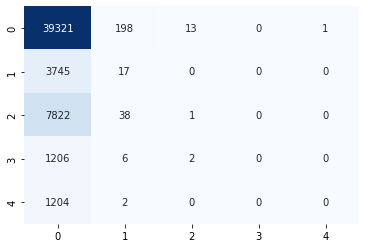

In [ ]:
y_true_cat = np.argmax(true_labels, -1)
pred_Y_cat = np.argmax(ensemble_predictions, -1)
pred_Y_cat = ensemble_predictions

from sklearn.metrics import accuracy_score, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_true_cat, pred_Y_cat)*100))
print(classification_report(y_true_cat, pred_Y_cat))

import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

## Averaging Ensemble Recall

In [ ]:
def retrieve_recall(nameModel):
  for elem in metric:
    if elem['name'] in nameModel:
      return elem['recall']

In [ ]:
def calculate_weights_recall(listModels):
  listWeights = []
  for elem in listModels:
    weight=0.0
    recall = retrieve_recall(elem['name'])
    for iteration,elem1 in enumerate(classifiers_weights):
      a = classifiers_weights[iteration]
      b = recall[iteration]
      partial = a * b
      weight += partial
    listWeights.append(weight)
  return listWeights

In [ ]:
listWeights = calculate_weights_recall(model_score_test)

In [ ]:
listWeights

[2.4085007,
 2.2173141000000003,
 2.0115139,
 1.9060592,
 1.8466786,
 1.7795477000000002,
 1.6849022,
 1.8755123,
 1.5676523000000002,
 1.5201096,
 1.6517867000000002,
 1.4922754999999999,
 1.8005792,
 1.5840353999999999,
 2.2071966,
 1.6049853,
 1.2894393,
 1.3373907999999999,
 1.3155522000000002,
 1.3275514,
 1.3689087999999998,
 1.5684957000000002,
 1.0255362000000001,
 0.3547437]

In [ ]:
ensemble_scores = []

n_models = len(model_score_test)
counter = 0

for i in range(len(true_labels)):
  listVotes = [0.0, 0.0, 0.0, 0.0, 0.0]
  for iteration,model_score in enumerate(model_score_test):
    accuracy = model_score['accuracy']
    score = model_score['scores'][i]
    listVotes[score] += 1*listWeights[iteration]
  if listVotes.count(max(listVotes))>1:
    counter +=1
  ensemble_scores.append(listVotes.index(max(listVotes)))
ensemble_predictions = np.array(ensemble_scores)
print(counter)

0


Accuracy on Test Data: 71.73%
              precision    recall  f1-score   support

           0       0.74      0.97      0.84     39533
           1       0.06      0.02      0.03      3762
           2       0.17      0.00      0.00      7861
           3       0.00      0.00      0.00      1214
           4       0.00      0.00      0.00      1206

    accuracy                           0.72     53576
   macro avg       0.19      0.20      0.17     53576
weighted avg       0.57      0.72      0.62     53576



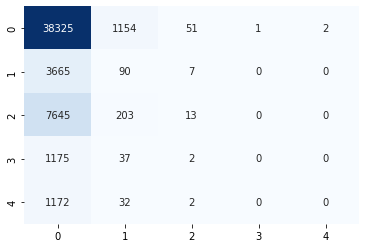

In [ ]:
y_true_cat = np.argmax(true_labels, -1)
pred_Y_cat = np.argmax(ensemble_predictions, -1)
pred_Y_cat = ensemble_predictions

from sklearn.metrics import accuracy_score, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_true_cat, pred_Y_cat)*100))
print(classification_report(y_true_cat, pred_Y_cat))

import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

# Model stacking


In [ ]:
BATCH_SIZE = 100
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
training_dir = PATH = '/content/trainingSet/'
validation_dir = PATH = '/content/validationSet/'

training_dataset = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

In [ ]:
from keras.layers.core import Lambda
from keras import backend as K
from keras.layers import Input

#load models
mobilenet_model = tf.keras.models.load_model('/content/drive/Shareddrives/DeepLearningProject/models/MobileNet/pretrained_MobileNet_exp4_adam_638c_0001.h5')
vgg16_model = tf.keras.models.load_model('/content/drive/Shareddrives/DeepLearningProject/models/VGG16/pretrained_VGG16_exp5_onmodel3_638c_0001_Adam.h5')
cnn_scratch_model = tf.keras.models.load_model('/content/drive/Shareddrives/DeepLearningProject/models/CNN_From_Scratch/59_model3.hdf5')

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

cnn_scratch = cnn_scratch_model(inputs)
vgg16 = vgg16_model(inputs)
mobilenet = mobilenet_model(inputs)

L1_layer = Lambda(lambda tensors:K.concatenate(tensors))
L1_concat = L1_layer([cnn_scratch, vgg16, mobilenet])

dense1 = tf.keras.layers.Dense(512, activation='relu')(L1_concat)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
prediction = tf.keras.layers.Dense(5,activation='softmax')(dense2)

model = models.Model(inputs,outputs=prediction)

tf.keras.utils.plot_model(model, to_file="img.png", show_shapes=True)

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/content/models'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)


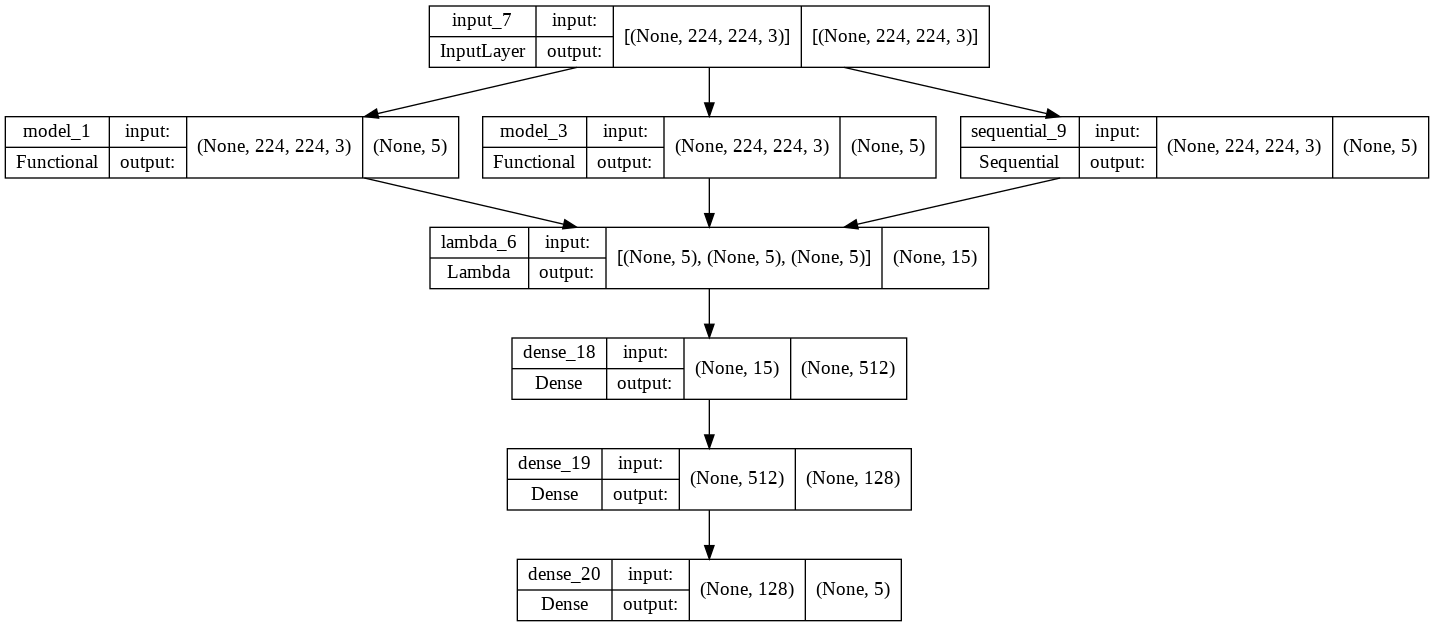

In [ ]:
tf.keras.utils.plot_model(model, to_file="img.png", show_shapes=True)

In [ ]:
history = model.fit(training_dataset,
          validation_data=validation_dataset,
          callbacks=[es,checkpoint],
          epochs=250)

Epoch 1/250
32/32 [==============================] - ETA: 0s - loss: 1.5058 - accuracy: 0.2947
Epoch 1: val_loss improved from inf to 1.32167, saving model to /content/models
32/32 [==============================] - 156s 3s/step - loss: 1.5058 - accuracy: 0.2947 - val_loss: 1.3217 - val_accuracy: 0.6900
Epoch 2/250
32/32 [==============================] - ETA: 0s - loss: 1.4295 - accuracy: 0.3464
Epoch 2: val_loss did not improve from 1.32167
32/32 [==============================] - 101s 3s/step - loss: 1.4295 - accuracy: 0.3464 - val_loss: 1.5305 - val_accuracy: 0.5630
Epoch 3/250
32/32 [==============================] - ETA: 0s - loss: 1.4090 - accuracy: 0.3473
Epoch 3: val_loss did not improve from 1.32167
32/32 [==============================] - 101s 3s/step - loss: 1.4090 - accuracy: 0.3473 - val_loss: 1.4214 - val_accuracy: 0.6496
Epoch 4/250
32/32 [==============================] - ETA: 0s - loss: 1.3512 - accuracy: 0.3837
Epoch 4: val_loss did not improve from 1.32167
32/32 [==

In [ ]:
# save model and model history
model.save("/content/drive/Shareddrives/DeepLearningProject/models/ensemble_512_Adam_0001.h5")



In [ ]:
with open("/content/drive/Shareddrives/DeepLearningProject/histories/Ensemble/ensemble_512_Adam_0001", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Test model

In [ ]:
with open('/content/drive/Shareddrives/DeepLearningProject/histories/Ensemble/ensemble_512_Adam_0001', 'rb') as file:
    history=pickle.load(file)

In [ ]:
from keras import backend as K
model = tf.keras.models.load_model("/content/drive/Shareddrives/DeepLearningProject/models/ensemble_512_Adam_0001.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


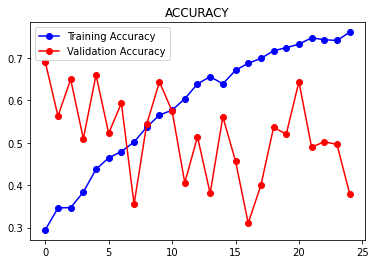

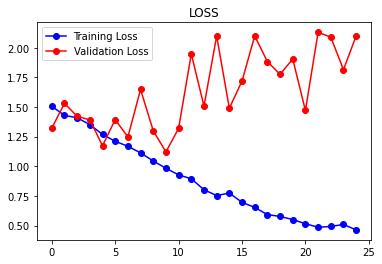

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
y_true_cat = np.argmax(y_true, -1)

In [ ]:
y_true_cat = np.argmax(true_labels, -1)

536/536 [==============================] - 298s 553ms/step
Accuracy on Test Data: 53.24%
              precision    recall  f1-score   support

           0       0.74      0.68      0.71     39533
           1       0.07      0.16      0.10      3762
           2       0.15      0.12      0.13      7861
           3       0.02      0.03      0.02      1214
           4       0.02      0.02      0.02      1206

    accuracy                           0.53     53576
   macro avg       0.20      0.20      0.20     53576
weighted avg       0.57      0.53      0.55     53576



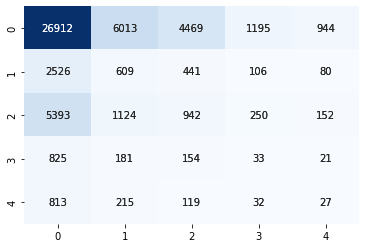

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

pred_Y = model.predict(test_dataset, batch_size = 512, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_true_cat, pred_Y_cat)*100))
print(classification_report(y_true_cat, pred_Y_cat))

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)